In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
# Paths to the main dataset and the splits
train_dir = '/content/drive/MyDrive/Dataset/Train'
test_dir = '/content/drive/MyDrive/Dataset/Test'

In [ ]:
# Image data generators for training and test
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

training_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # DenseNet121 input size
    batch_size=32,
    class_mode='categorical'
)

test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Do not shuffle for evaluation
)

Found 5450 images belonging to 10 classes.
Found 1367 images belonging to 10 classes.


In [ ]:
# Load the DenseNet121 model with pre-trained weights, excluding the top layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

29084464/29084464 [==============================] - 2s 0us/step


In [ ]:
# Create a new model with additional layers
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(10, activation='softmax')  # 10 classes
])

In [ ]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
# Define callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

In [ ]:
# Train the model
history = model.fit(
    training_set,
    steps_per_epoch=training_set.samples // training_set.batch_size,
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/10
170/170 [==============================] - ETA: 0s - loss: 0.0248 - accuracy: 0.9970

170/170 [==============================] - 90s 525ms/step - loss: 0.0248 - accuracy: 0.9970
Epoch 2/10
170/170 [==============================] - ETA: 0s - loss: 0.0254 - accuracy: 0.9970

170/170 [==============================] - 88s 515ms/step - loss: 0.0254 - accuracy: 0.9970
Epoch 3/10
170/170 [==============================] - ETA: 0s - loss: 0.0216 - accuracy: 0.9969

170/170 [==============================] - 86s 508ms/step - loss: 0.0216 - accuracy: 0.9969
Epoch 4/10
170/170 [==============================] - ETA: 0s - loss: 0.0203 - accuracy: 0.9978

170/170 [==============================] - 84s 497ms/step - loss: 0.0203 - accuracy: 0.9978
Epoch 5/10
170/170 [==============================] - ETA: 0s - loss: 0.0174 - accuracy: 0.9970

170/170 [==============================] - 87s 514ms/step - loss: 0.0174 - accuracy: 0.9970
Epoch 6/10
170/170 [==============================] - ETA: 0s - loss: 0.0149 - accuracy: 0.9989

170/170 [==============================] - 86s 501ms/step - loss: 0.0149 - accuracy: 0.9989
Epoch 7/10
170/170 [==============================] - ETA: 0s - loss: 0.0146 - accuracy: 0.9987

170/170 [==============================] - 87s 512ms/step - loss: 0.0146 - accuracy: 0.9987
Epoch 8/10
170/170 [==============================] - ETA: 0s - loss: 0.0162 - accuracy: 0.9983

170/170 [==============================] - 85s 497ms/step - loss: 0.0162 - accuracy: 0.9983
Epoch 9/10
170/170 [==============================] - ETA: 0s - loss: 0.0154 - accuracy: 0.9976

170/170 [==============================] - 84s 494ms/step - loss: 0.0154 - accuracy: 0.9976
Epoch 10/10
170/170 [==============================] - ETA: 0s - loss: 0.0168 - accuracy: 0.9978

170/170 [==============================] - 86s 502ms/step - loss: 0.0168 - accuracy: 0.9978


In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_set, steps=test_set.samples // test_set.batch_size)
print(f'Validation Loss: {loss:.4f}')
print(f'Validation: {accuracy:.4f}')

42/42 [==============================] - 940s 23s/step - loss: 0.0381 - accuracy: 0.9888
Validation Loss: 0.0381
Validation: 0.9888


In [ ]:
model.save('/content/drive/MyDrive/Dataset/DenseNet121.h5')
print("Model saved to disk.")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to disk.


In [ ]:
# Predict on the test set
Y_pred = model.predict(test_set, steps=test_set.samples // test_set.batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)

43/43 [==============================] - 7s 159ms/step


In [ ]:
y_true = test_set.classes

In [ ]:
print('Classification Report')
target_names = list(test_set.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=target_names))

Classification Report
                  precision    recall  f1-score   support

    Chhattisgarh       1.00      0.98      0.99       129
         Gujarat       1.00      1.00      1.00       179
         Haryana       0.99      0.98      0.99       128
Himachal Pradesh       0.95      0.98      0.97       128
      Karanataka       1.00      0.97      0.98       129
          Kerala       0.99      1.00      1.00       138
     Maharashtra       0.99      0.99      0.99       150
         Manipur       1.00      1.00      1.00       129
         Mizoram       0.98      0.98      0.98       129
     West Bengal       0.99      0.99      0.99       128

        accuracy                           0.99      1367
       macro avg       0.99      0.99      0.99      1367
    weighted avg       0.99      0.99      0.99      1367



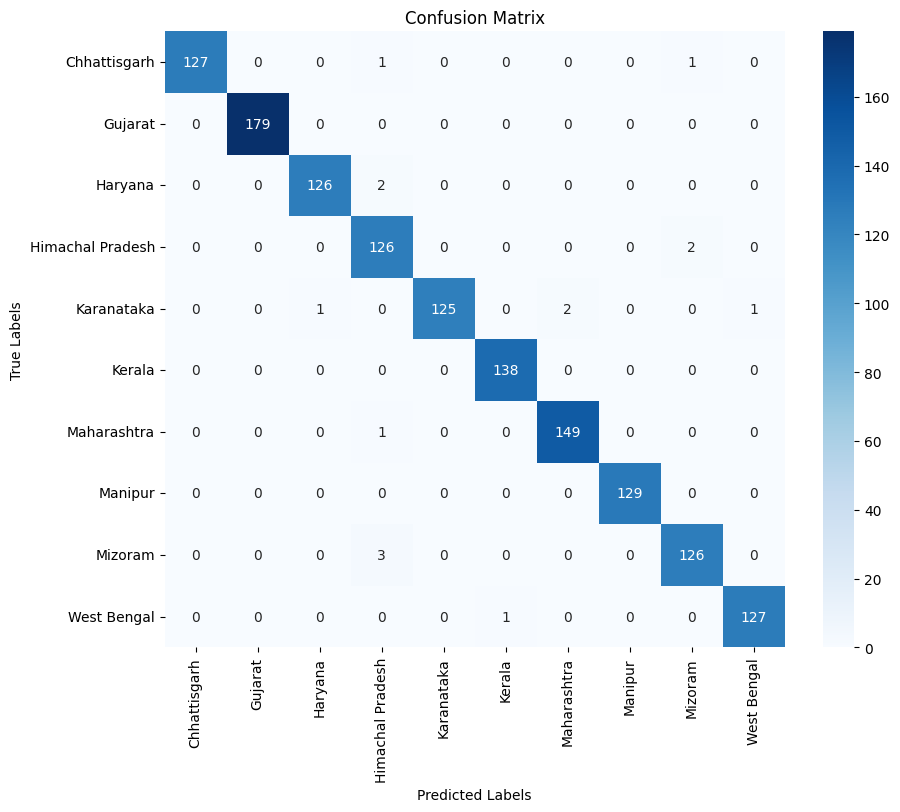

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

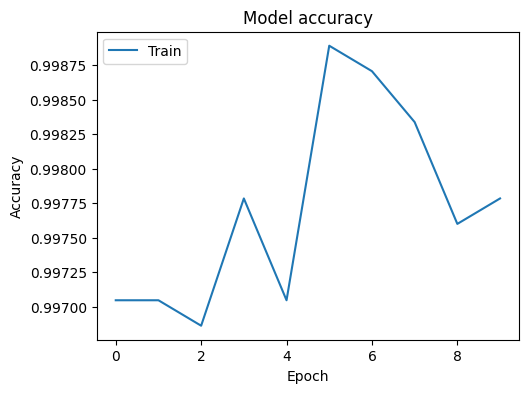

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

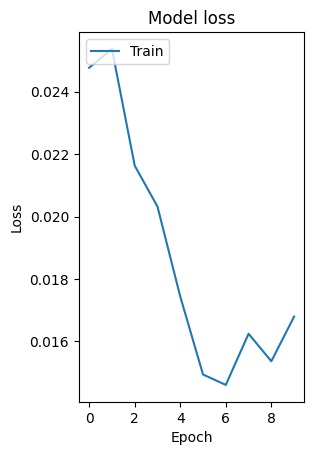

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121

# Load your trained model or pretrained model
# Assuming you have trained your ResNet50V2 model for spice classification
model =DenseNet121(weights='imagenet')  # Replace with your actual trained model
test_score = [0.0, 0.98]  # Replace with your actual test scores

# Compile the model to avoid warning about compiled metrics
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define model name directly
model_name = 'DenseNet121'
subject = 'State Wise Costume Image Classification'
acc = test_score[1] * 100  # Assuming test_score[1] is the accuracy
save_path = '/content/drive/MyDrive/Dataset'  # Specify your desired save path

# Create the filename for saving the model
save_id = f'{model_name}-{subject}-{"%.2f" % round(acc, 2)}.keras'
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Create the filename for saving the weights
weight_save_id = f'{model_name}-{subject}-weights.keras'
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

33188688/33188688 [==============================] - 0s 0us/step
model was saved as /content/drive/MyDrive/Dataset/DenseNet121-State Wise Costume Image Classification-98.00.keras
weights were saved as /content/drive/MyDrive/Dataset/DenseNet121-State Wise Costume Image Classification-weights.keras
